# Кто выживет в крушении титаника?

Класический проект из Kaggle о крушении титаника. Задача построить прогрозную модель, которая определеит, какие поссажиры выжили. Итоговый результат это `.csv` файл, в котором перечесленны 418 выживших в крушении.

In [ ]:
pip install -q phik

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score

try:
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError:
    print('Код выполняется вне Google Colab.')

RANDOM_STATE = 42

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Загрузка и изучение данных

In [ ]:
try:
    train = pd.read_csv('titanic/train.csv')
    test = pd.read_csv('titanic/test.csv')
except FileNotFoundError:
    try:
        train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/titanic/data/raw/train.csv')  # Для Google Colab
        test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/titanic/data/raw/test.csv')
    except FileNotFoundError:
        print('Файл не найден ни в одном из указанных мест.')

**Описание данных**

Variable|Definition|Key
|-|-|-|
survival|Survival|0 = No, 1 = Yes
pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd
sex|Sex
Age|Age in years|
sibsp|# of siblings / spouses aboard the Titanic
parch|# of parents / children aboard the Titanic
ticket|Ticket number
fare|Passenger fare
cabin|Cabin number
embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton

In [ ]:
def chek(df, name=None):
    display(df.head())
    display(df.tail())
    print()
    display(df.info())
    print()
    display(df.describe(include='all'))

    if name:
        print(f'\nДатасет {name}, имеет {df.shape[0]} строк и {df.shape[1]} столбцов')
    else:
        print(f'\nДатасет имеет {df.shape[0]} строк и {df.shape[1]} столбцов')

In [ ]:
chek(train, 'train')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Dooley, Mr. Patrick",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN



Датасет train, имеет 891 строк и 12 столбцов


In [ ]:
chek(test)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


None

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Peter, Master. Michael J",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN



Датасет имеет 418 строк и 11 столбцов


In [ ]:
# Разделение на числовые столбцы
num_col = train.select_dtypes(include=['number']).columns
num_col = num_col.drop('PassengerId')
print(num_col)

# Разделение на дискретные и непрерывные
continuous_col = []
discrete_col = []

for i in num_col:
    if train[i].nunique() < 10:
        discrete_col.append(i)
    else:
        continuous_col.append(i)

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')


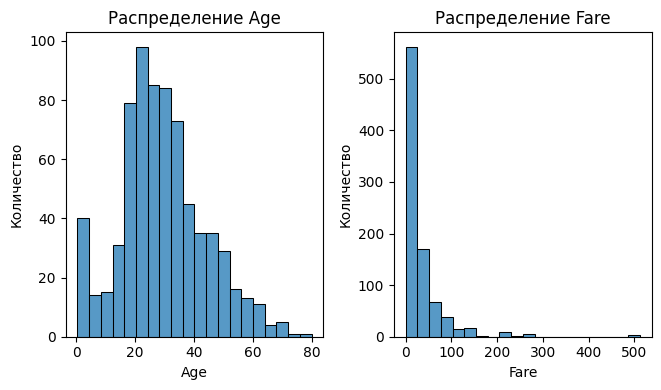

In [ ]:
# Настройка параметров графиков
n_col = 3
n_row = (len(continuous_col) + n_col - 1) // n_col

if continuous_col:
    # Создание фигуры и осей
    fig, axes = plt.subplots(n_row, n_col, figsize=(10, 4))
    axes = axes.flatten()  # Преобразуем в одномерный массив

    # Цикл по непрерывным столбцам
    for i, col in enumerate(continuous_col):
        sns.histplot(data=train, x=col, ax=axes[i], bins=20, edgecolor='black')
        axes[i].set_title(f'Распределение {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Количество")

    # Удаляем пустые оси
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()  # Автоматически настраиваем расположение
    plt.show()

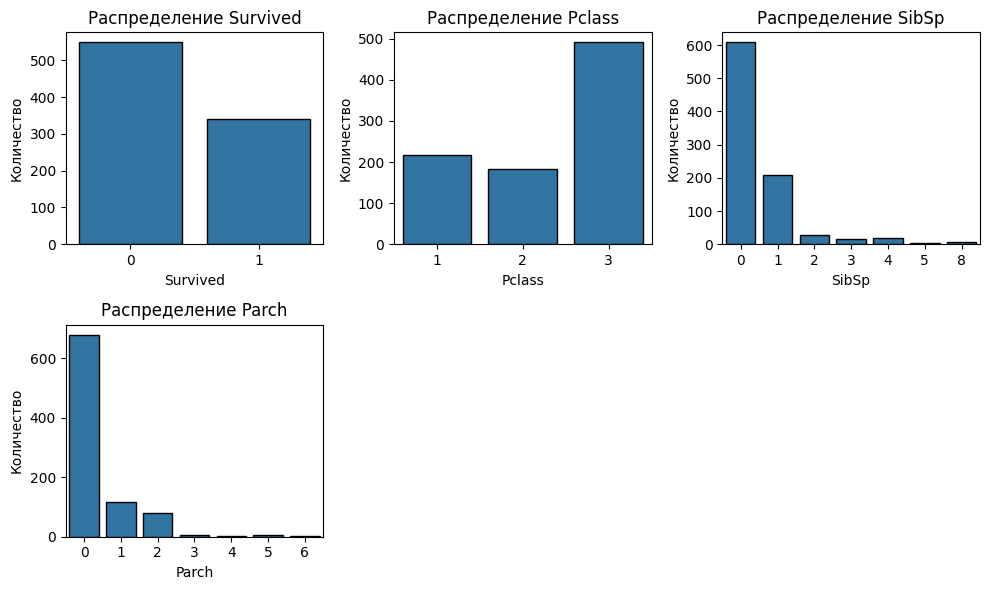

In [ ]:
# Настройка параметров графиков
n_col = 3
n_row = (len(discrete_col) + n_col - 1) // n_col

if continuous_col:
    # Создание фигуры и осей
    fig, axes = plt.subplots(n_row, n_col, figsize=(10, 6))
    axes = axes.flatten()  # Преобразуем в одномерный массив

    # Цикл по непрерывным столбцам
    for i, col in enumerate(discrete_col):
        sns.countplot(data=train, x=col, ax=axes[i], edgecolor='black')
        axes[i].set_title(f'Распределение {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Количество")

    # Удаляем пустые оси
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()  # Автоматически настраиваем расположение
    plt.show()

Датасет `train` имеет размерность 891 строк и 12 стобцов. Видны проспуски в датасете, в столцах: `Age`, `Cabine` и `Embarked`. Столбцы записаны форматом camel, что не значительною. Целевая переменная в столбце `Survived` представлена в типе данных `int`.

Датасет `test` имеет размерность 418 строк и 11 столцов, целовой столбец `Survived` исключен из стоблицы. В датасете также присудствуют пропуски, в столбцах: `Age`, `Cabine` и один пропуск в `Fare`.

## Предобработка данных

Иследуем количество пропусков в каждом датасете подробнее

In [ ]:
# Определим количество пропущенных значений в каждом столбце
missing_values = train.isna().sum()
missing_percentage = ((missing_values / len(train)) * 100).round(2)

missing_info = pd.DataFrame({'пропусков': missing_values, 'в процентах': missing_percentage})
display(missing_info)

,пропусков,в процентах
PassengerId,0,0.00
Survived,0,0.00
Pclass,0,0.00
Name,0,0.00
Sex,0,0.00
Age,177,19.87
SibSp,0,0.00
Parch,0,0.00
Ticket,0,0.00
Fare,0,0.00


In [ ]:
display(train[train['Age'].isna()].head())
display(train[train['Age'].isna()].tail())
print((train[train['Age'].isna()]).shape)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


(177, 12)


Определить точную причину появления пропусков в столбце `Age` не удалось. Одна из заментных деталей, в том что если пропуск присудствует в `Age`, то пропуск скорее всего присудствует и в `Cabin`, но это связанно с большим количествоми пропусков в самом столбце `Cabin` - 77% от общего размера датасета.

In [ ]:
# Заполним пропуски в `Age` модой
train['Age'] = train['Age'].fillna(train['Age'].mode()[0])

In [ ]:
# Заполним пропуски в `Embarked` модой
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])

In [ ]:
# Избавимся от пропусков установив заглушку
train['Cabin'] = train['Cabin'].fillna('Unknown')

In [ ]:
# Изменим категориальный признак `Cabin`
train['Cabin_letter'] = train['Cabin'].str[0]  # Только первая буква: 'C', 'A', 'B' и заглушка U
train = train.drop(columns=['Cabin'], axis=1)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin_letter
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,U
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,U
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,U


In [ ]:
train.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


Перейдем к преобработке данных в `test`

In [ ]:
test.query('Fare.isna()')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [ ]:
test['Fare'] = test['Fare'].fillna(test['Fare'].mode()[0])

In [ ]:
# Избавимся от пропусков установив заглушку
test['Cabin'] = test['Cabin'].fillna('Unknown')

In [ ]:
# Изменим категориальный признак `Cabin`
test['Cabin_letter'] = test['Cabin'].str[0]  # Только первая буква: 'C', 'A', 'B' и заглушка U
test = test.drop(columns=['Cabin'], axis=1)
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin_letter
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,U
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,U
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,U
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,U
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,U


In [ ]:
# Заполним пропуски в столбце возвраст, модой
test['Age'] = test['Age'].fillna(test['Age'].mode()[0])

In [ ]:
test.isna().sum()

,0
PassengerId,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0
Embarked,0


## Иследовательский анализ данных

Более подробнее изучим количество факт выжвания относительно признаков в датасете. Определим:  
- Пассажири какого класса чаще выживали
- Определим факт влияния возвраста и пола на выживание

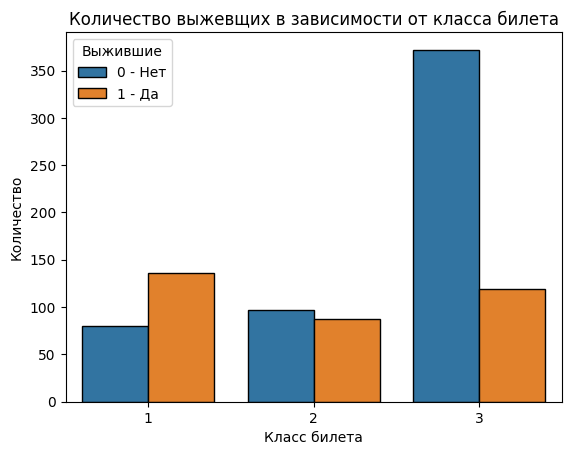

In [ ]:
# Изучим пассажиров
sns.countplot(data=train, x='Pclass', hue='Survived', edgecolor='black')
plt.title('Количество выжевщих в зависимости от класса билета')
plt.xlabel('Класс билета')
plt.ylabel('Количество')
plt.legend(title='Выжившие', labels=['0 - Нет', '1 - Да'])
plt.show()

In [ ]:
# Для изучение возвраста выделим группы в признаке `Age`
age = []
for i in train.Age:
    if i <= 25:
        age.append('до и 25')
    elif i > 25 and i <= 50:
        age.append('от 25 до и 50')
    elif i > 50:
        age.append('от 50')

train['AgeGroup'] = age
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin_letter,AgeGroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,U,до и 25
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,от 25 до и 50
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,U,от 25 до и 50
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,C,от 25 до и 50
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,U,от 25 до и 50


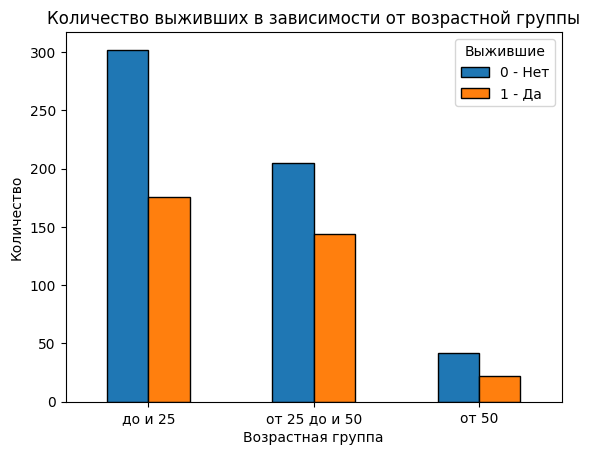

In [ ]:
train.groupby(['AgeGroup', 'Survived']).size().unstack(fill_value=0).plot(
    kind='bar', edgecolor='black')
plt.title('Количество выживших в зависимости от возрастной группы')
plt.xlabel('Возрастная группа')
plt.ylabel('Количество')
plt.xticks(rotation=0) # Поворачиваем подписи оси x для лучшей читаемости
plt.legend(title='Выжившие', labels=['0 - Нет', '1 - Да'])
plt.show()

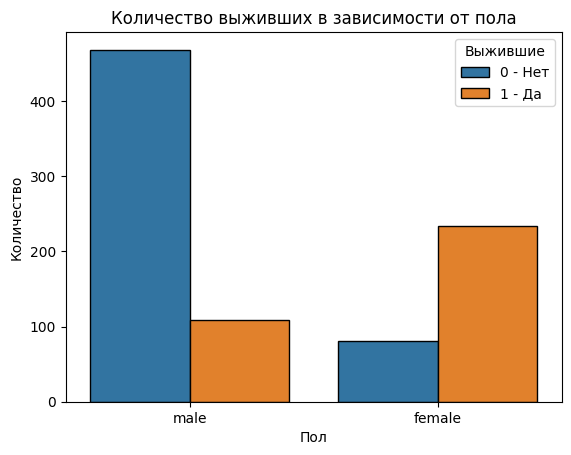

In [ ]:
# Визуализируем выживаемость по полу
sns.countplot(data=train, x='Sex', hue='Survived', edgecolor='black')
plt.title('Количество выживших в зависимости от пола')
plt.xlabel('Пол')
plt.ylabel('Количество')
plt.legend(title='Выжившие', labels=['0 - Нет', '1 - Да'])
plt.show()

Промежуточный итог:
- Пассажиры 1-го класса имели более высокую выживаемость по сравнению с пассажирами 2-го и 3-го классов.
- Возрастная группа "Группа до 25" (дети и молодежь) имела более высокий шанс на выживание, чем более старшие возрастные группы.
- Женщины имели значительно более высокую выживаемость по сравнению с мужчинами.

## Построение матрицы корреляции

Для построения матрицы корреляции будем использовать phik_matrix

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   891 non-null    int64  
 1   Survived      891 non-null    int64  
 2   Pclass        891 non-null    int64  
 3   Name          891 non-null    object 
 4   Sex           891 non-null    object 
 5   Age           891 non-null    float64
 6   SibSp         891 non-null    int64  
 7   Parch         891 non-null    int64  
 8   Ticket        891 non-null    object 
 9   Fare          891 non-null    float64
 10  Embarked      891 non-null    object 
 11  Cabin_letter  891 non-null    object 
 12  AgeGroup      891 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


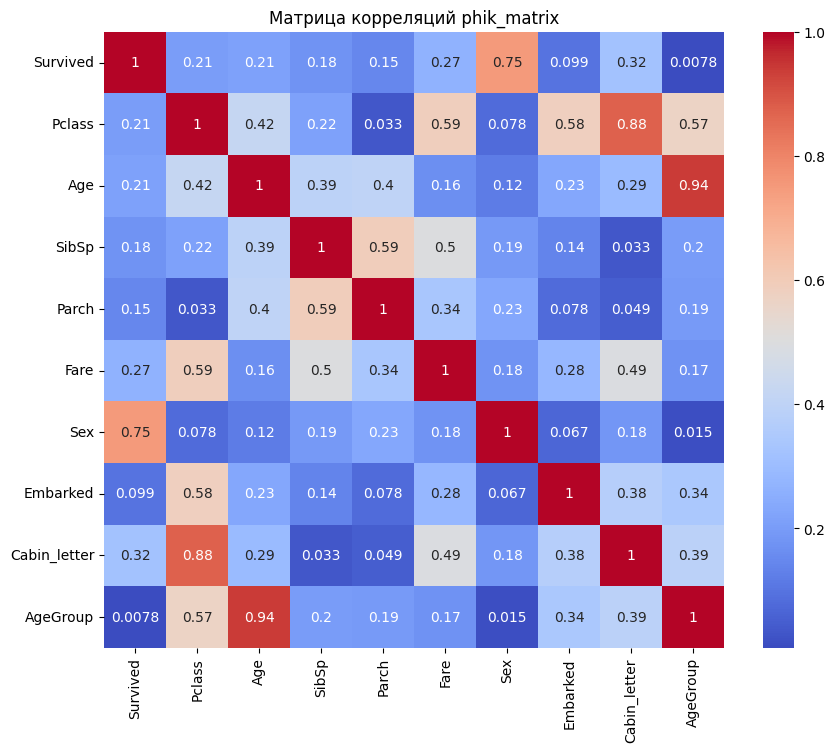

In [ ]:
# Пример использования phik_matrix с интервальными столбцами
# Определите ваши интервальные столбцы. В данном случае, 'Age' и 'Fare'
interval_cols = ['Age', 'Fare']

# Визуализация матрицы корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(train[num_col.tolist() + ['Sex'] + ['Embarked'] + ['Cabin_letter'] + ['AgeGroup']].phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm')
plt.title('Матрица корреляций phik_matrix')
plt.show()

Анализ матрицы корреляции phik_matrix:  

- `Survived` (выживаемость) имеет наиболее сильную корреляцию с `Sex`, что подтверждает, что пол был ключевым фактором выживаемости.
- `Survived` (выживаемость) также заметно коррелирует с `Pclass`, `Age` и `Fare`. Пассажиры 1-го класса, более молодые пассажиры и те, кто заплатил больше, имели более высокие шансы выжить.
- `Cabin_letter` (буква каюты) показывает умеренную корреляцию с `Survived`, а также сильную корреляцию с `Pclass` и `Fare`, что логично, поскольку класс билета и стоимость связаны с расположением каюты.
- `SibSp` (количество братьев/сестер/супругов) и `Parch` (количество родителей/детей) имеют более низкую корреляцию с `Survived`, но сильную корреляцию между собой, указывая на связь с размером семьи.
- `Embarked` (порт посадки) и `AgeGroup` (возрастная группа) имеет слабую корреляцию с `Survived`.

In [ ]:
# Для наглядности построим таблицу корреляции признаков относительно целевого
train[num_col.tolist() + ['Sex'] + ['Embarked'] + ['Cabin_letter'] + ['AgeGroup']
      ].phik_matrix(interval_cols=interval_cols)['Survived'].sort_values(ascending=False)

,Survived
Survived,1.000000
Sex,0.750322
Cabin_letter,0.321486
Fare,0.265387
Age,0.214174
Pclass,0.205464
SibSp,0.175652
Parch,0.147080
Embarked,0.099149
AgeGroup,0.007833


Определим признаки для удаления на основе отсортированной корреляции с `Survived`:  
Примем порог корреляции `phik < 0.1`, ниже которого признаки будут удалены.  

Исходя из отсортированной таблицы, удалим `Embarked` и `AgeGroup`. Также удалим столбец `Name`, `Ticket`, а `PassengerId` установим новым индексом для таблице, нумерация которого начинается с единицы.

In [ ]:
# Удалим столбцы из обучающего датасета
train = train.drop(columns=['Embarked', 'AgeGroup', 'Name', 'Ticket'], axis=1)

# Удалим столбец из тестового датасета
test = test.drop(columns=['Embarked', 'Name', 'Ticket'], axis=1)

# Установим столбец 'PassengerId' как индекс
train = train.set_index('PassengerId')
test = test.set_index('PassengerId')

print("Обучающий датасет после удаления признаков:")
display(train.head())
print("\nТестовый датасет после удаления признаков:")
display(test.head())

Обучающий датасет после удаления признаков:


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin_letter
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,U
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,U
4,1,1,female,35.0,1,0,53.1000,C
5,0,3,male,35.0,0,0,8.0500,U



Тестовый датасет после удаления признаков:


,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin_letter
PassengerId,,,,,,,
892,3,male,34.5,0,0,7.8292,U
893,3,female,47.0,1,0,7.0000,U
894,2,male,62.0,0,0,9.6875,U
895,3,male,27.0,0,0,8.6625,U
896,3,female,22.0,1,1,12.2875,U


# Подготовка и обучение модели

Подготовим датасеты `train`.  
Резделим, датасет `train` на `X_train`, `X_val`, `y_train`, `y_val`.  
Датасет `train` не содержит целевого признака и используется, только для конечного предсказания.

In [ ]:
train['Pclass'].value_counts()

,count
Pclass,
3,491
1,216
2,184


In [ ]:
# Разделим датасет `train` на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(train.drop('Survived', axis=1),
                                                  train['Survived'], test_size=0.2, random_state=42)

In [ ]:
# Определение столбцов для различных типов кодирования
ohe_cols = ['Sex', 'Cabin_letter'] # One-Hot Encoding
ord_cols = ['Pclass'] # Ordinal Encoding
num_cols = ['Age', 'SibSp', 'Parch', 'Fare'] # Numerical columns

# Создаем обработчик данных One-Hot Encoding
ohe_pipe = Pipeline(
                    [
                        ('simple_imuter_before_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
                    ]
                    )

ord_pipe = Pipeline(
                    [
                        ('simple_imuter_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                        ('ord', OrdinalEncoder(categories=[[1, 2, 3]], handle_unknown='use_encoded_value', unknown_value=np.nan)),
                        ('simple_imuter_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
                    ]
                    )

# Пайплайн для числовых
num_pip = Pipeline(
                   [
                       ('scaler', StandardScaler())
                   ]
                   )

# Создание трансформеров для каждого типа столбцов
preprocessor = ColumnTransformer(
                                transformers=[
                                    ('ohe', ohe_pipe, ohe_cols),
                                    ('ord', ord_pipe, ord_cols),
                                    ('num', num_pip, num_cols)
                                             ],
                                remainder='passthrough' # остальные столбцы останутся без изменений
                                )

# Создание пайплайна с препроцессором и моделью логистической регрессии
pipeline = Pipeline(
                    [
                        ('preprocessor', preprocessor),
                        ('classifier', LogisticRegression(random_state=RANDOM_STATE))
                    ]
                    )

In [ ]:
# Создание списка/словаря с гиперпараметрами
param_pipe = [
                # Настройка перебора для LogisticRegression
              {
                'classifier': [LogisticRegression(random_state=RANDOM_STATE)],
                'classifier__C': range(1, 10),
                'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
              },
                # Настройка перебора для RandomForestClassifier
              {
                'classifier': [RandomForestClassifier(random_state=RANDOM_STATE)],
                'classifier__n_estimators': range(1, 100, 10),
                'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
              },
                # Настройка перебора для DecisionTreeClassifier
              {
                'classifier': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
                'classifier__max_depth': range(1, 10),
                'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
              },
                # Настройка перебора для GaussianNB
              {
                'classifier': [GaussianNB()],
                'classifier__var_smoothing': range(1, 10),
                'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
              }
             ]

## Обучение модели

Для перебора гиперпараметров будем использовать RandomizedSearchCV

In [ ]:
# Инициализация RandomizedSearchCV
random_search = RandomizedSearchCV(
            pipeline,
            param_pipe,
            scoring='roc_auc',
            n_jobs=-1,
            random_state=RANDOM_STATE,
)

# Обучение модели
random_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simple_imuter_before_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['Sex',
                                                                                'Cabin_letter']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simple_imu...
                                        {'classifier': [DecisionTreeClassifier(random_state=42)],
                                         'classifier__max_depth': range(1, 10),
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       'passthrough']},
                                        {'classifier': [GaussianNB()],
                                         'classifier__var_smoothing': range(1, 10),
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [ ]:
print('Лучшая модель и её параметры:\n\n', random_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', random_search.best_score_)

# проверим работу модели на валидационной выборке и получим прогноз на тестовых данных
y_val_pred = random_search.predict_proba(X_val)[:,1]
print(f'Метрика ROC-AUC на валидационной выборке: {roc_auc_score(y_val, y_val_pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simple_imuter_before_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Cabin_letter']),
                                                 ('ord',
                                                  Pipeline(steps=[('simple_imuter_before_ord',
     

In [ ]:
# Добавим прогнозы в датасет в виде целого числа
y_test_pred = random_search.predict_proba(test)[:,1]
test['Survived'] = y_test_pred.round().astype(int)

# Устанавливаем новый индекс
test = test.reset_index()

# Выводим результат обучения
display(test[['PassengerId', 'Survived']].head())

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
